In [1]:
"""
Test for band correlations and perform standard scaling of band values
"""

import os
import xarray as xr
import rioxarray as rxr
import rasterio as rio
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'

print("Imports successful!")

Imports successful!


In [2]:
def print_raster(raster, open_file):
    """
    :param raster: input raster file
    :param open_file: should the file be opened or not
    :return: print statement with raster information
    """
    if open_file is True:
        img = rxr.open_rasterio(raster,masked=True, cache=False).squeeze()
    else:
        img = raster
    print(
        f"shape: {img.rio.shape}\n"
        f"resolution: {img.rio.resolution()}\n"
        f"bounds: {img.rio.bounds()}\n"
        f"sum: {img.sum().item()}\n"
        f"CRS: {img.rio.crs}\n"
        f"NoData: {img.rio.nodata}"
        f"Array: {img}"
    )
    del img


print("Functions ready to use!")

Functions ready to use!


In [3]:
# Load our image data to check on the format
stack_da_fp = os.path.join(maindir,'data/spatial/mod/dc_data/planet-data/dc_data_psscene15b.tif')
stack_da = rxr.open_rasterio(stack_da_fp, masked=True, cache=False).squeeze()
print_raster(stack_da, open_file=False)
band_names = stack_da.long_name
print(band_names)

shape: (7555, 6046)
resolution: (3.0, -3.0)
bounds: (316269.0, 4295631.0, 334407.0, 4318296.0)
sum: 180264534016.0
CRS: EPSG:32618
NoData: NoneArray: <xarray.DataArray (band: 15, y: 7555, x: 6046)> Size: 3GB
[685162950 values with dtype=float32]
Coordinates:
  * band         (band) int64 120B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * x            (x) float64 48kB 3.163e+05 3.163e+05 ... 3.344e+05 3.344e+05
  * y            (y) float64 60kB 4.318e+06 4.318e+06 ... 4.296e+06 4.296e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_IMAGEDESCRIPTION:  {"atmospheric_correction": {"aerosol_model": "...
    TIFFTAG_DATETIME:          2022:06:05 14:56:31
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        15203
    STATISTICS_MEAN:           662.44066810447
    STATISTICS_MINIMUM:        80
    STATISTICS_STDDEV:         475.12461911944
    STATISTICS_VALID_PERCENT:  42.96
    scale_factor:              1.0
    add_offset:                0.0

In [4]:
# Convert to a numpy array and test band correlations
image_np = stack_da.values

# img_data is now a numpy array of shape (bands, height, width)
print(f"Image data shape: {image_np.shape}")
print(f"Data type: {image_np.dtype}")

# Check if the data contains only zeros or NaNs
print(f"Data contains NaNs: {np.isnan(image_np).any()}")
print(f"Data contains only zeros: {np.all(image_np == 0)}")

Image data shape: (15, 7555, 6046)
Data type: float32
Data contains NaNs: True
Data contains only zeros: False


In [5]:
# Reshape the data to (bands, pixels)
bands, height, width = image_np.shape
image_np_t = image_np.reshape(bands, -1).T  # Transpose to get shape (pixels, bands)

# Create a mask for non-NaN values
valid_mask = ~np.isnan(image_np_t).any(axis=1)
# Handle NaN for the correlation matrix
image_np_tm = image_np_t[valid_mask]

# Check if the data contains only zeros or NaNs
print(f"Data contains NaNs: {np.isnan(image_np_tm).any()}")
print(f"Data contains only zeros: {np.all(image_np_tm == 0)}")

Data contains NaNs: False
Data contains only zeros: False


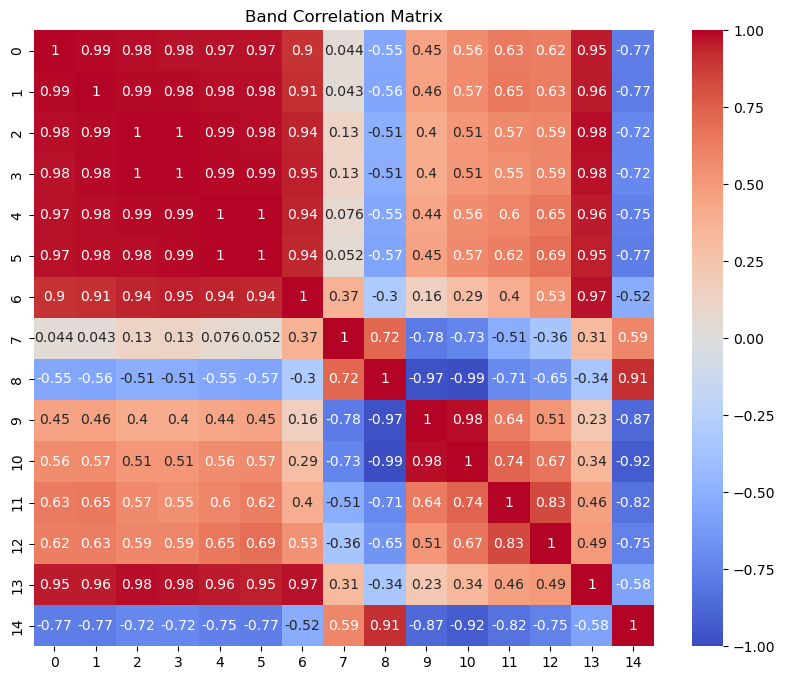

In [6]:
# Calculate the correlation matrix
cor_mat_tm = np.corrcoef(image_np_tm, rowvar=False)

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cor_mat_tm, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Band Correlation Matrix')

plt.savefig(os.path.join(maindir,'figures/FigX_band_correlations.png'), dpi=300, bbox_inches='tight')

plt.show()

In [7]:
# Normalize the image data
scaler = StandardScaler()
image_np_tmn = scaler.fit_transform(image_np_tm)

# Reshape normalized data back to (bands, height, width)

# Create an empty array and place the normalized values back into the original shape
image_np_tmn_r = np.full(image_np_t.shape, np.nan)
image_np_tmn_r[valid_mask] = image_np_tmn
image_np_tmn_r = image_np_tmn_r.T.reshape(bands, height, width)

# Convert the normalized array back to a DataArray
image_norm = xr.DataArray(
    image_np_tmn_r,
    dims=stack_da.dims,
    coords=stack_da.coords,
    attrs=stack_da.attrs
)

print(image_norm.shape)
print(image_norm)

(15, 7555, 6046)
<xarray.DataArray (band: 15, y: 7555, x: 6046)> Size: 5GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        

In [8]:
# Save the normalized image array out with the correct CRS and compression
image_norm_fp = os.path.join(maindir,'data/spatial/mod/dc_data/planet-data/dc_data_psscene15b_norm.tif')
image_norm.rio.to_raster(image_norm_fp, compress='zstd', zstd_level=9, driver='GTiff', dtype='float32')

In [9]:
# Save a version of the image data without the original bands

# Remove bands 0-6 from the normalized data (highly correlated)
image_norm_reduc = image_np_tmn_r[7:, :, :]
print(f"Updated band names: {band_names[7:]}")
print(f"New image shape: {image_norm_reduc.shape}")

Updated band names: ('nir', 'ndre', 'vgnir', 'vrnir', 'ndbibg', 'ndbirg', 'mnf1', 'mnf2')
New image shape: (8, 7555, 6046)


Data contains NaNs after reduction: False
Data contains only zeros after reduction: False


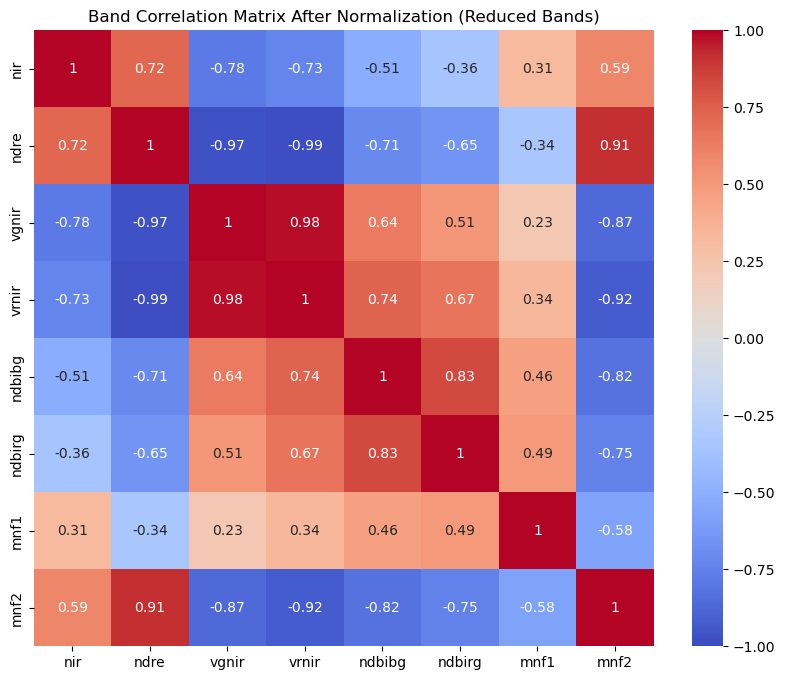

In [10]:
# Calculate the correlation matrix for the remaining bands

image_norm_reduc_r_f = image_norm_reduc.reshape(len(band_names[7:]), -1).T
valid_mask_r = ~np.isnan(image_norm_reduc_r_f).any(axis=1)
image_norm_reduc_r_f = image_norm_reduc_r_f[valid_mask_r]

# Check if the data contains only zeros or NaNs
print(f"Data contains NaNs after reduction: {np.isnan(image_norm_reduc_r_f).any()}")
print(f"Data contains only zeros after reduction: {np.all(image_norm_reduc_r_f == 0)}")

# Calculate the correlation matrix
cor_mat_r = np.corrcoef(image_norm_reduc_r_f, rowvar=False)

# Plot the correlation matrix for the remaining bands
plt.figure(figsize=(10, 8))
sns.heatmap(cor_mat_r, annot=True, cmap='coolwarm', vmin=-1, vmax=1, xticklabels=band_names[7:], yticklabels=band_names[7:])
plt.title('Band Correlation Matrix After Normalization (Reduced Bands)')
plt.savefig(os.path.join(maindir, 'figures/FigX_band_correlations_after_reduced.png'), dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# Convert the reduced normalized array back to a DataArray
image_norm_reduc_da = xr.DataArray(
    image_norm_reduc,
    dims=['band', 'y', 'x'],
    coords={
        'band': np.arange(len(band_names[7:])),
        'y': stack_da.coords['y'],
        'x': stack_da.coords['x']
    },
    attrs=stack_da.attrs
)

# Update the long_name attribute and band coords
image_norm_reduc_da = image_norm_reduc_da.assign_coords(band=np.array(band_names[7:]))
image_norm_reduc_da.attrs['long_name'] = tuple(band_names[7:])

# Ensure the CRS attribute is properly assigned
image_norm_reduc_da.rio.write_crs(stack_da.rio.crs, inplace=True)

print(image_norm_reduc_da.shape)
print_raster(image_norm_reduc_da, open_file=False)

(8, 7555, 6046)
shape: (7555, 6046)
resolution: (3.0, -3.0)
bounds: (316269.0, 4295631.0, 334407.0, 4318296.0)
sum: -0.21569510297558736
CRS: EPSG:32618
NoData: NoneArray: <xarray.DataArray (band: 8, y: 7555, x: 6046)> Size: 3GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, na

In [18]:
# Save the normalized image array out with the correct CRS and compression
image_norm_reduc_fp = os.path.join(maindir,'data/spatial/mod/dc_data/planet-data/dc_data_psscene15b_norm_r.tif')
image_norm_reduc_da.rio.to_raster(image_norm_reduc_fp, compress='zstd', zstd_level=9, driver='GTiff', dtype='float32')